In [100]:
import numpy as np
from pyquil.quil import Program
from pyquil.api import QVMConnection, QPUConnection
from pyquil.gates import I, RX, RY, RZ, MEASURE, H
from pyquil.paulis import PauliTerm, exponential_map, sX, sY, sZ
from grove.tomography.state_tomography import do_state_tomography
from matplotlib import pyplot as plt

## Noisy state preparation

In [147]:
def prepareNoisyT(qubit):
    theta = np.pi - 2 * np.arctan(np.sqrt(2+np.sqrt(3)))
    phi = np.pi/4
    prog = Program(RY(theta,qubit),RZ(phi,qubit))
    return prog

## Distillation

In [12]:
def ZZ(qubit1, qubit2):
    operators = [("Z",qubit1),("Z",qubit2)]
    exponent = PauliTerm.from_list(operators)
    return exponential_map(exponent)

In [45]:
def distillation(prog):

    # Step 1

    prog.inst(RX(-np.pi/4,0), ZZ(1,2)(np.pi/4), RZ(np.pi/2,3), RY(np.pi/4,4))

    # Step 2

    prog.inst(RZ(np.pi,1))

    # Step 3

    prog.inst(RX(-np.pi/4,1), RY(np.pi/4,2))

    # Step 4

    prog.inst(ZZ(0,1)(np.pi/4), ZZ(2,3)(np.pi/4))

    # Step 5

    prog.inst(RX(-np.pi/4,1),RY(-np.pi/4,2),RX(-np.pi/4,3))

    # Step 6

    prog.inst(ZZ(1,2)(np.pi/4), ZZ(3,4)(np.pi/4))

    # Step 7

    prog.inst(RY(np.pi/4,1), RY(np.pi/4,2), RY(np.pi/4,3), RX(np.pi/4,4))

    # Step 8

    prog.inst(ZZ(0,1)(np.pi/4),ZZ(1,2)(np.pi/4),ZZ(2,3)(np.pi/4))

    # Step 9

    prog.inst(RY(-np.pi/4,0),RY(np.pi/4,1),RY(-np.pi/4,2),RX(-np.pi/4,3))
    
    return prog

## Combine stages

In [150]:
qubits = range(5)
prog = Program([prepareNoisyT(qubit) for qubit in qubits])
prog = distillation(prog)
#prog.inst(MEASURE(0,0),MEASURE(2,2),MEASURE(3,3),MEASURE(4,4))

## Preliminary tests

In [144]:
qvm = QVMConnection()
n = 10000
runs = qvm.run(prog,classical_addresses=[0,2,3,4],trials=n)
sum([run == [0,0,0,0] for run in runs])/n

1.0

In [92]:
operators = [op(1) for op in [X,Y,Z]]
paulis = qvm.expectation(prog, operator_programs = operators)
print(paulis)

[0.01679869243644233, 0.9381328771718196, -0.3458677618711409]


## Tomography

In [128]:
def state_tomography(Program, NumSamples, qubits, QVMorQPU):
    if(QVMorQPU == 0):
        state_tomography_qvm, _, _ = do_state_tomography(Program, NumSamples, qvm, qubits)
        print(state_tomography_qvm.rho_est)
        state_tomography_qvm.plot()
    if(QVMorQPU == 1):
        state_tomography_qpu, _, _ = do_state_tomography(Program, NumSamples, qpu, qubits)
        state_tomography_qpu.plot()
    plt.show()

100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.47999231+0.j         0.28000004+0.03001005j]
 [0.28000004-0.03001005j 0.52000605+0.j        ]]


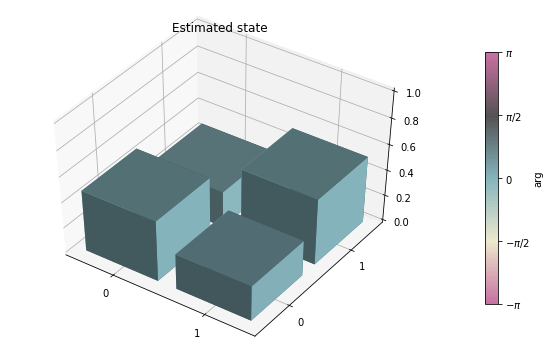

In [151]:
state_tomography(prog,100,[1],0)

100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.78449991+0.j         0.29699995-0.29299995j]
 [0.29699995+0.29299995j 0.21549997+0.j        ]]


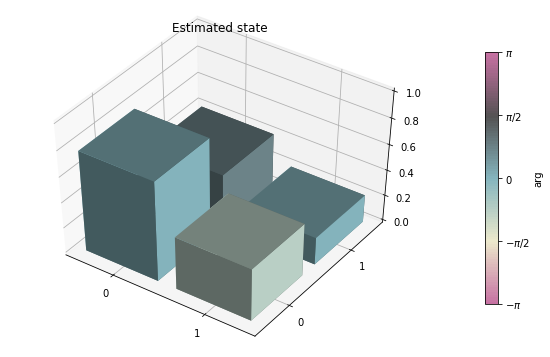

In [149]:
state_tomography(prepareNoisyT(1),1000,[1],0)